In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers


In [2]:
def error_rate(label, prediction, ft_len, forecast_len):
    error_avg = 0
    ft_len = ft_len-1
    for i in range(forecast_len):
        error = abs((label[ft_len+i,0,0] - prediction[ft_len,i,0])/label[ft_len+i,0,0] * 100)
        print('num',i,error,'actual',label[ft_len+i,0,0],'prediction',predictions[ft_len,i,0])
        error_avg = error_avg + error
    error_avg = error_avg/forecast_len
    return error_avg

In [3]:
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable."""
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P

In [4]:

# Initialization for system model.
A = 1
H = 1
Q = 0.1
R = 7
# Initialization for estimation.
x_0 = 10  # 14 for book.
P_0 = 6

In [5]:
forecasting = 20

In [6]:
df = pd.read_csv('trainset/J0003_0024_0222_20110307012737_cell_1.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,1,0.259,2.23,-20
1,2011.3.7 18:29,1,0.260,2.23,-20
2,2011.3.8 6:29,1,0.259,2.23,-20
3,2011.3.8 18:29,1,0.259,2.23,-20
4,2011.3.9 6:29,1,0.259,2.23,-20
...,...,...,...,...,...
254,2011.8.30 5:28,1,0.301,2.23,-20
255,2011.8.30 17:28,1,0.301,2.23,-20
256,2011.8.31 5:28,1,0.302,2.23,-20
257,2011.8.31 16:09,1,0.300,2.23,-20


In [7]:
df = df['Resistance']
df

0      0.259
1      0.260
2      0.259
3      0.259
4      0.259
       ...  
254    0.301
255    0.301
256    0.302
257    0.300
258    0.296
Name: Resistance, Length: 259, dtype: float64

<AxesSubplot:>

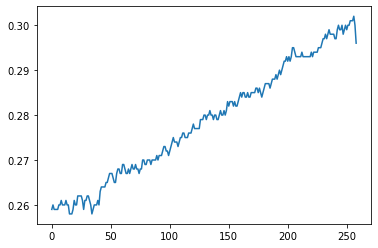

In [8]:
df.plot()

In [9]:
n_samples = len(df)
x_0 = df[1]
r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = df[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

df = r_esti_save

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Resistance']
df = pd.DataFrame(df)
df.columns = scale_cols
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(type(df_scaled))

<class 'pandas.core.frame.DataFrame'>


In [11]:
train = df_scaled

In [12]:
def make_dataset(data, label, window_size=forecasting):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [13]:
feature_cols = ['Resistance']
label_cols = ['Resistance']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, forecasting)
total_len = len(train_feature)

x_train = train_feature[:int(total_len*0.8)]
x_valid = train_feature[int(total_len*0.8):]
y_train = train_label[:int(total_len*0.8)]
y_valid = train_label[int(total_len*0.8):]

In [14]:
x_train.shape

(191, 20, 1)

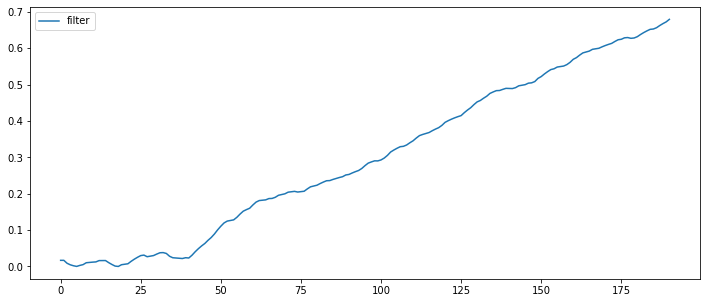

In [15]:
plt.figure(figsize=(12,5))
plt.plot(x_train[:,0,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

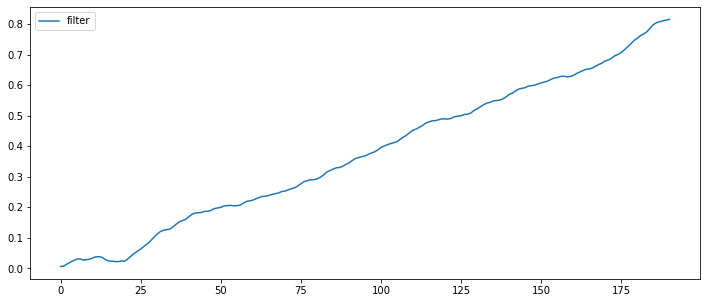

In [16]:
y_train.shape
plt.figure(figsize=(12,5))
plt.plot(y_train[:,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [17]:
OUT_STEPS = 20

In [18]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(30, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(tf.keras.layers.Dense(OUT_STEPS*1))
model.add(tf.keras.layers.Reshape([OUT_STEPS, 1]))

In [19]:
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(lr=0.001), metrics=[tf.metrics.MeanAbsoluteError()])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('models/', 'kjgreftmp_checkpoint.h5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

h = model.fit(x_train, x_train, 
                    epochs=1000, 
                    batch_size=16)

Epoch 1/1000
12/12 [==============================] - 1s 5ms/step - loss: 0.1564 - mean_absolute_error: 0.3255
Epoch 2/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.1314 - mean_absolute_error: 0.2914
Epoch 3/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0931 - mean_absolute_error: 0.2372
Epoch 4/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0521 - mean_absolute_error: 0.1648
Epoch 5/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.1070
Epoch 6/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.0100 - mean_absolute_error: 0.0783
Epoch 7/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0061 - mean_absolute_error: 0.0634
Epoch 8/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0039 - mean_absolute_error: 0.0495
Epoch 9/1000
12/12 [==============================] - 0s 4ms/step - loss: 0.0035 - mean_absolute_error: 0.0466
E

12/12 [==============================] - 0s 4ms/step - loss: 9.0718e-05 - mean_absolute_error: 0.0075
Epoch 73/1000
12/12 [==============================] - 0s 4ms/step - loss: 1.0033e-04 - mean_absolute_error: 0.0078
Epoch 74/1000
12/12 [==============================] - 0s 4ms/step - loss: 9.3217e-05 - mean_absolute_error: 0.0077
Epoch 75/1000
12/12 [==============================] - 0s 4ms/step - loss: 8.2462e-05 - mean_absolute_error: 0.0072
Epoch 76/1000
12/12 [==============================] - 0s 4ms/step - loss: 8.6483e-05 - mean_absolute_error: 0.0073
Epoch 77/1000
12/12 [==============================] - 0s 5ms/step - loss: 8.2848e-05 - mean_absolute_error: 0.0072
Epoch 78/1000
12/12 [==============================] - 0s 5ms/step - loss: 8.3828e-05 - mean_absolute_error: 0.0073
Epoch 79/1000
12/12 [==============================] - 0s 4ms/step - loss: 8.9189e-05 - mean_absolute_error: 0.0074
Epoch 80/1000
12/12 [==============================] - 0s 4ms/step - loss: 8.7361e-05 

12/12 [==============================] - 0s 4ms/step - loss: 7.7073e-05 - mean_absolute_error: 0.0071
Epoch 143/1000
12/12 [==============================] - 0s 4ms/step - loss: 7.5531e-05 - mean_absolute_error: 0.0070
Epoch 144/1000
12/12 [==============================] - 0s 5ms/step - loss: 7.5145e-05 - mean_absolute_error: 0.0070
Epoch 145/1000
12/12 [==============================] - 0s 4ms/step - loss: 7.6246e-05 - mean_absolute_error: 0.0071
Epoch 146/1000
12/12 [==============================] - 0s 4ms/step - loss: 7.2487e-05 - mean_absolute_error: 0.0069
Epoch 147/1000
12/12 [==============================] - 0s 4ms/step - loss: 7.2714e-05 - mean_absolute_error: 0.0069
Epoch 148/1000
12/12 [==============================] - 0s 4ms/step - loss: 7.5253e-05 - mean_absolute_error: 0.0071
Epoch 149/1000
12/12 [==============================] - 0s 5ms/step - loss: 7.4130e-05 - mean_absolute_error: 0.0070
Epoch 150/1000
12/12 [==============================] - 0s 4ms/step - loss: 7.1

12/12 [==============================] - 0s 5ms/step - loss: 6.1781e-05 - mean_absolute_error: 0.0063
Epoch 213/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.5484e-05 - mean_absolute_error: 0.0066
Epoch 214/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.4768e-05 - mean_absolute_error: 0.0065
Epoch 215/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.5561e-05 - mean_absolute_error: 0.0066
Epoch 216/1000
12/12 [==============================] - 0s 4ms/step - loss: 7.2754e-05 - mean_absolute_error: 0.0070
Epoch 217/1000
12/12 [==============================] - 0s 4ms/step - loss: 7.2105e-05 - mean_absolute_error: 0.0069
Epoch 218/1000
12/12 [==============================] - 0s 5ms/step - loss: 7.0661e-05 - mean_absolute_error: 0.0068
Epoch 219/1000
12/12 [==============================] - 0s 5ms/step - loss: 7.0986e-05 - mean_absolute_error: 0.0068
Epoch 220/1000
12/12 [==============================] - 0s 5ms/step - loss: 6.8

12/12 [==============================] - 0s 4ms/step - loss: 6.6033e-05 - mean_absolute_error: 0.0066
Epoch 283/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.7096e-05 - mean_absolute_error: 0.0067
Epoch 284/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.3305e-05 - mean_absolute_error: 0.0065
Epoch 285/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.2871e-05 - mean_absolute_error: 0.0064
Epoch 286/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.1947e-05 - mean_absolute_error: 0.0064
Epoch 287/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.5720e-05 - mean_absolute_error: 0.0066
Epoch 288/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.3861e-05 - mean_absolute_error: 0.0065
Epoch 289/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.1276e-05 - mean_absolute_error: 0.0064
Epoch 290/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.0

12/12 [==============================] - 0s 4ms/step - loss: 6.1537e-05 - mean_absolute_error: 0.0063
Epoch 353/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.4001e-05 - mean_absolute_error: 0.0065
Epoch 354/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.8371e-05 - mean_absolute_error: 0.0062
Epoch 355/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.9339e-05 - mean_absolute_error: 0.0062
Epoch 356/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.8736e-05 - mean_absolute_error: 0.0062
Epoch 357/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.0311e-05 - mean_absolute_error: 0.0063
Epoch 358/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.9146e-05 - mean_absolute_error: 0.0062
Epoch 359/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.3195e-05 - mean_absolute_error: 0.0059
Epoch 360/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.2

12/12 [==============================] - 0s 5ms/step - loss: 7.7701e-05 - mean_absolute_error: 0.0069
Epoch 423/1000
12/12 [==============================] - 0s 5ms/step - loss: 4.2775e-05 - mean_absolute_error: 0.0051
Epoch 424/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.1553e-05 - mean_absolute_error: 0.0043
Epoch 425/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.5297e-05 - mean_absolute_error: 0.0046
Epoch 426/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.2939e-05 - mean_absolute_error: 0.0045
Epoch 427/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.4859e-05 - mean_absolute_error: 0.0053
Epoch 428/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.8810e-05 - mean_absolute_error: 0.0061
Epoch 429/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.2476e-05 - mean_absolute_error: 0.0051
Epoch 430/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.6

12/12 [==============================] - 0s 4ms/step - loss: 2.6845e-05 - mean_absolute_error: 0.0040
Epoch 493/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.7846e-05 - mean_absolute_error: 0.0041
Epoch 494/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.7741e-05 - mean_absolute_error: 0.0041
Epoch 495/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.9615e-05 - mean_absolute_error: 0.0043
Epoch 496/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.7394e-05 - mean_absolute_error: 0.0040
Epoch 497/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.4739e-05 - mean_absolute_error: 0.0039
Epoch 498/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.0513e-05 - mean_absolute_error: 0.0043
Epoch 499/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.2401e-05 - mean_absolute_error: 0.0045
Epoch 500/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.8

12/12 [==============================] - 0s 4ms/step - loss: 2.6722e-05 - mean_absolute_error: 0.0041
Epoch 562/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.5934e-05 - mean_absolute_error: 0.0040
Epoch 563/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.1103e-05 - mean_absolute_error: 0.0044
Epoch 564/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.6052e-05 - mean_absolute_error: 0.0040
Epoch 565/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.5028e-05 - mean_absolute_error: 0.0038
Epoch 566/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.5283e-05 - mean_absolute_error: 0.0039
Epoch 567/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.5901e-05 - mean_absolute_error: 0.0039
Epoch 568/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.5718e-05 - mean_absolute_error: 0.0039
Epoch 569/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.8

12/12 [==============================] - 0s 4ms/step - loss: 2.9974e-05 - mean_absolute_error: 0.0043
Epoch 632/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.4668e-05 - mean_absolute_error: 0.0038
Epoch 633/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.4122e-05 - mean_absolute_error: 0.0038
Epoch 634/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.5071e-05 - mean_absolute_error: 0.0039
Epoch 635/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.0320e-05 - mean_absolute_error: 0.0043
Epoch 636/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.2248e-05 - mean_absolute_error: 0.0045
Epoch 637/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.2745e-05 - mean_absolute_error: 0.0045
Epoch 638/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.7810e-05 - mean_absolute_error: 0.0049
Epoch 639/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.8

12/12 [==============================] - 0s 4ms/step - loss: 3.4597e-05 - mean_absolute_error: 0.0047
Epoch 702/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.6057e-05 - mean_absolute_error: 0.0047
Epoch 703/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.0217e-05 - mean_absolute_error: 0.0043
Epoch 704/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.4753e-05 - mean_absolute_error: 0.0039
Epoch 705/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.8615e-05 - mean_absolute_error: 0.0042
Epoch 706/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.6360e-05 - mean_absolute_error: 0.0040
Epoch 707/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.1641e-05 - mean_absolute_error: 0.0036
Epoch 708/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.1422e-05 - mean_absolute_error: 0.0036
Epoch 709/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.3

12/12 [==============================] - 0s 4ms/step - loss: 2.8073e-05 - mean_absolute_error: 0.0042
Epoch 771/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.9382e-05 - mean_absolute_error: 0.0043
Epoch 772/1000
12/12 [==============================] - 0s 5ms/step - loss: 4.1560e-05 - mean_absolute_error: 0.0050
Epoch 773/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.9308e-05 - mean_absolute_error: 0.0043
Epoch 774/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.4176e-05 - mean_absolute_error: 0.0038
Epoch 775/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.1550e-05 - mean_absolute_error: 0.0036
Epoch 776/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.3329e-05 - mean_absolute_error: 0.0037
Epoch 777/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.4755e-05 - mean_absolute_error: 0.0039
Epoch 778/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.2

12/12 [==============================] - 0s 4ms/step - loss: 2.2331e-05 - mean_absolute_error: 0.0037
Epoch 841/1000
12/12 [==============================] - 0s 4ms/step - loss: 1.9791e-05 - mean_absolute_error: 0.0034
Epoch 842/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.1470e-05 - mean_absolute_error: 0.0036
Epoch 843/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.0307e-05 - mean_absolute_error: 0.0034
Epoch 844/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.0144e-05 - mean_absolute_error: 0.0035
Epoch 845/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.1408e-05 - mean_absolute_error: 0.0036
Epoch 846/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.1750e-05 - mean_absolute_error: 0.0036
Epoch 847/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.4846e-05 - mean_absolute_error: 0.0038
Epoch 848/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.4

12/12 [==============================] - 0s 4ms/step - loss: 2.4334e-05 - mean_absolute_error: 0.0039
Epoch 911/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.9364e-05 - mean_absolute_error: 0.0042
Epoch 912/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.5007e-05 - mean_absolute_error: 0.0039
Epoch 913/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.4207e-05 - mean_absolute_error: 0.0038
Epoch 914/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.2899e-05 - mean_absolute_error: 0.0038
Epoch 915/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.0783e-05 - mean_absolute_error: 0.0036
Epoch 916/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.0906e-05 - mean_absolute_error: 0.0035
Epoch 917/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.2146e-05 - mean_absolute_error: 0.0036
Epoch 918/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.1

12/12 [==============================] - 0s 4ms/step - loss: 2.2412e-05 - mean_absolute_error: 0.0037
Epoch 981/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.7839e-05 - mean_absolute_error: 0.0041
Epoch 982/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.5275e-05 - mean_absolute_error: 0.0039
Epoch 983/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.4328e-05 - mean_absolute_error: 0.0045
Epoch 984/1000
12/12 [==============================] - 0s 4ms/step - loss: 1.4622e-04 - mean_absolute_error: 0.0095
Epoch 985/1000
12/12 [==============================] - 0s 4ms/step - loss: 7.0622e-05 - mean_absolute_error: 0.0065
Epoch 986/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.8606e-05 - mean_absolute_error: 0.0058
Epoch 987/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.7742e-05 - mean_absolute_error: 0.0041
Epoch 988/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.3

num 0 19.356100375835794 actual 0.6190476190476186 prediction 0.7388711
num 1 12.96466588974009 actual 0.6666666666666661 prediction 0.7530978
num 2 5.778372287750357 actual 0.7142857142857135 prediction 0.7555598
num 3 0.3872498869897041 actual 0.7619047619047628 prediction 0.7589543
num 4 6.994071006775017 actual 0.7142857142857135 prediction 0.76424336
num 5 15.018406510353191 actual 0.6666666666666661 prediction 0.7667894
num 6 16.812732815742596 actual 0.6666666666666661 prediction 0.77875155
num 7 17.364963889122116 actual 0.6666666666666661 prediction 0.7824331
num 8 11.715857982635617 actual 0.7142857142857135 prediction 0.7979704
num 9 12.460492849350095 actual 0.7142857142857135 prediction 0.80328923
num 10 14.871904850006226 actual 0.7142857142857135 prediction 0.8205136
num 11 24.484601616859546 actual 0.6666666666666661 prediction 0.82989734
num 12 17.513128519058352 actual 0.7142857142857135 prediction 0.8393795
num 13 11.8158623576163 actual 0.7619047619047628 prediction

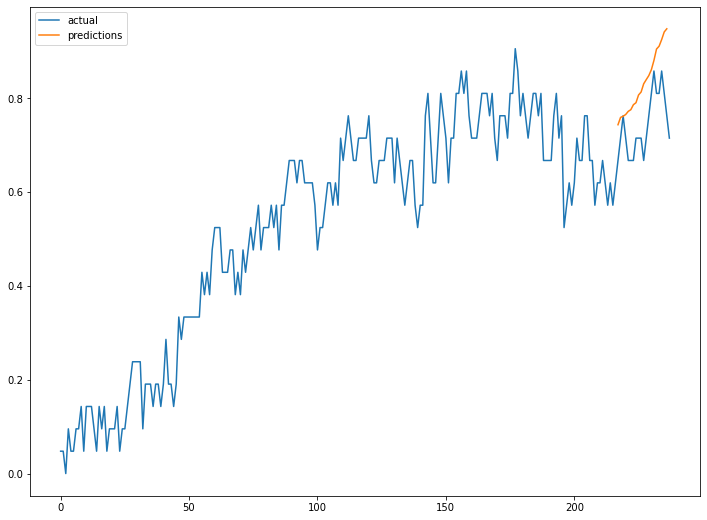

In [20]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 4.0135919317907 actual 0.8006535947712417 prediction 0.7685186
num 1 3.215685150315686 actual 0.8104575163398693 prediction 0.78439575
num 2 3.0902125749243305 actual 0.8137254901960784 prediction 0.78857964
num 3 3.878701639175413 actual 0.8169934640522876 prediction 0.7853047
num 4 3.4304375648498517 actual 0.8169934640522876 prediction 0.788967
num 5 4.134737590394644 actual 0.8202614379084967 prediction 0.7863458
num 6 3.8158579306168927 actual 0.826797385620915 prediction 0.795248
num 7 4.654247965663662 actual 0.8366013071895424 prediction 0.7976638
num 8 4.39671218165098 actual 0.8464052287581698 prediction 0.8091912
num 9 4.741609918660115 actual 0.8529411764705881 prediction 0.81249803
num 10 3.479016053812567 actual 0.8594771241830064 prediction 0.8295758
num 11 3.555399179458598 actual 0.8627450980392155 prediction 0.83207107
num 12 3.6964533463963707 actual 0.8660130718954246 prediction 0.8340013
num 13 2.389211069862776 actual 0.8660130718954246 prediction 0.8453222


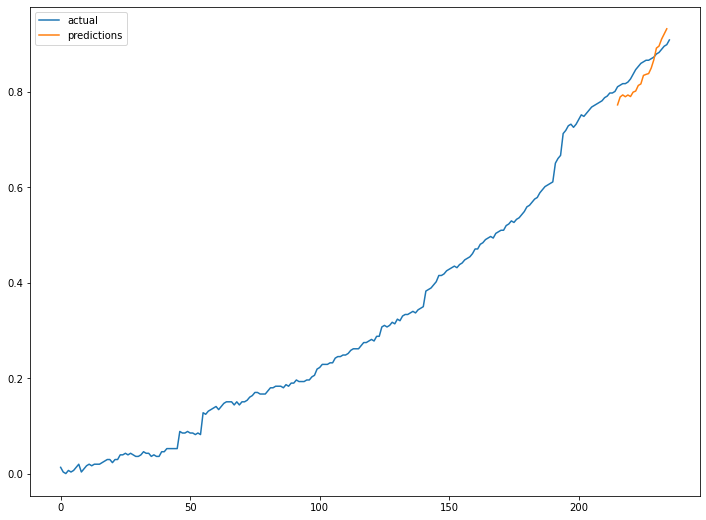

In [21]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_06.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 0.22935183812293325 actual 0.6762402088772845 prediction 0.6777912
num 1 0.6231230090964767 actual 0.6892950391644908 prediction 0.6849999
num 2 1.1613931325490745 actual 0.6971279373368144 prediction 0.68903154
num 3 1.2636973512216798 actual 0.702349869451697 prediction 0.6934743
num 4 0.8836677593498472 actual 0.7075718015665795 prediction 0.7013192
num 5 1.0545068413671814 actual 0.7154046997389034 prediction 0.7078607
num 6 1.8497276049788247 actual 0.7284595300261096 prediction 0.714985
num 7 2.6907783725657684 actual 0.7389033942558747 prediction 0.71902114
num 8 2.4841138087083054 actual 0.7493472584856395 prediction 0.7307326
num 9 2.23324560789087 actual 0.7545691906005221 prediction 0.7377178
num 10 2.550787994886006 actual 0.7650130548302871 prediction 0.7454992
num 11 1.749678614999169 actual 0.7676240208877285 prediction 0.75419307
num 12 0.4857828827942388 actual 0.7676240208877285 prediction 0.76389503
num 13 0.5437642735922756 actual 0.7780678851174934 prediction

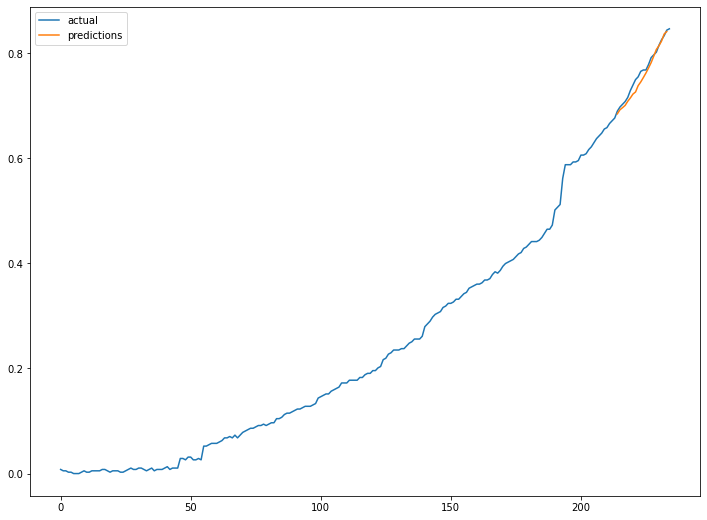

In [22]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_7.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 1.1537426396419388 actual 0.7916666666666661 prediction 0.7825329
num 1 1.7257263785915133 actual 0.7916666666666661 prediction 0.80532867
num 2 2.1667229501825394 actual 0.7916666666666661 prediction 0.8088199
num 3 7.675512631734212 actual 0.75 prediction 0.80756634
num 4 3.0612368332713045 actual 0.7916666666666661 prediction 0.81590146
num 5 8.773795763651531 actual 0.75 prediction 0.81580347
num 6 1.0995864868164764 actual 0.8333333333333339 prediction 0.8241701
num 7 0.5336117744446508 actual 0.8333333333333339 prediction 0.82888657
num 8 7.699088616804584 actual 0.9166666666666661 prediction 0.8460917
num 9 11.022839338883164 actual 0.9583333333333339 prediction 0.8526978
num 10 8.698569173398282 actual 0.9583333333333339 prediction 0.87497205
num 11 8.291134626969104 actual 0.9583333333333339 prediction 0.8788766
num 12 8.102655410766658 actual 0.9583333333333339 prediction 0.8806829
num 13 6.6610481428064015 actual 0.9583333333333339 prediction 0.8944983
num 14 0.2124071

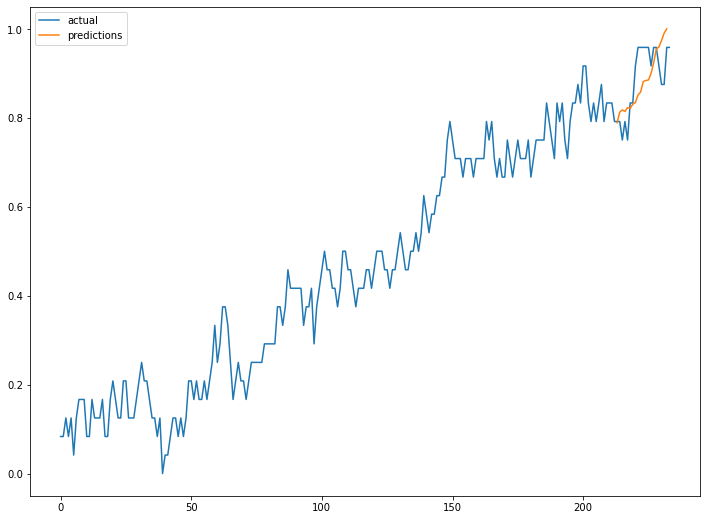

In [23]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_9.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 4.152623226768077 actual 0.8482142857142856 prediction 0.81299114
num 1 2.435253063837644 actual 0.8571428571428568 prediction 0.83626926
num 2 0.8210242422003347 actual 0.8482142857142856 prediction 0.84125024
num 3 2.555777265139246 actual 0.8526785714285712 prediction 0.830886
num 4 4.054284833141188 actual 0.8660714285714284 prediction 0.8309584
num 5 6.327445166451591 actual 0.875 prediction 0.81963485
num 6 5.5323712111729515 actual 0.8794642857142856 prediction 0.83080906
num 7 6.3715211111097085 actual 0.8883928571428568 prediction 0.8317887
num 8 4.52621633356265 actual 0.8839285714285712 prediction 0.84392005
num 9 5.017134891682494 actual 0.8883928571428568 prediction 0.843821
num 10 1.5841320307567586 actual 0.8839285714285712 prediction 0.869926
num 11 2.8861083984374933 actual 0.8928571428571428 prediction 0.8670883
num 12 4.139698141872259 actual 0.901785714285714 prediction 0.8644545
num 13 3.1667775121228448 actual 0.90625 prediction 0.8775511
num 14 0.8121490478

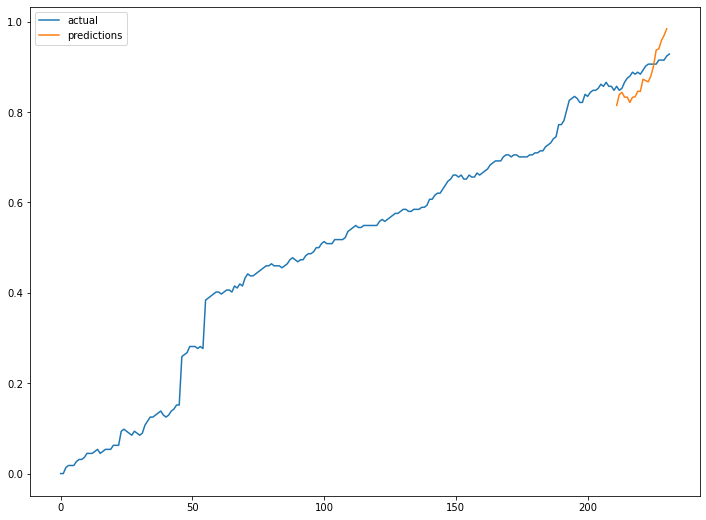

In [24]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_18.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 4.378414154052894 actual 0.8500000000000014 prediction 0.8127835
num 1 4.097925126552489 actual 0.8000000000000007 prediction 0.8327834
num 2 11.632450421651203 actual 0.75 prediction 0.8372434
num 3 10.08290449778239 actual 0.75 prediction 0.8256218
num 4 9.595974286397297 actual 0.75 prediction 0.8219698
num 5 7.9277753829956055 actual 0.75 prediction 0.8094583
num 6 17.027640342712225 actual 0.7000000000000011 prediction 0.8191935
num 7 17.021824632371995 actual 0.7000000000000011 prediction 0.8191528
num 8 27.313173734224687 actual 0.6500000000000004 prediction 0.8275356
num 9 17.84398555755597 actual 0.7000000000000011 prediction 0.8249079
num 10 13.04012934366862 actual 0.75 prediction 0.84780097
num 11 12.440172831217449 actual 0.75 prediction 0.8433013
num 12 19.785078934260593 actual 0.7000000000000011 prediction 0.83849555
num 13 21.306146894182294 actual 0.7000000000000011 prediction 0.849143
num 14 8.397603034973049 actual 0.8000000000000007 prediction 0.8671808
num 1

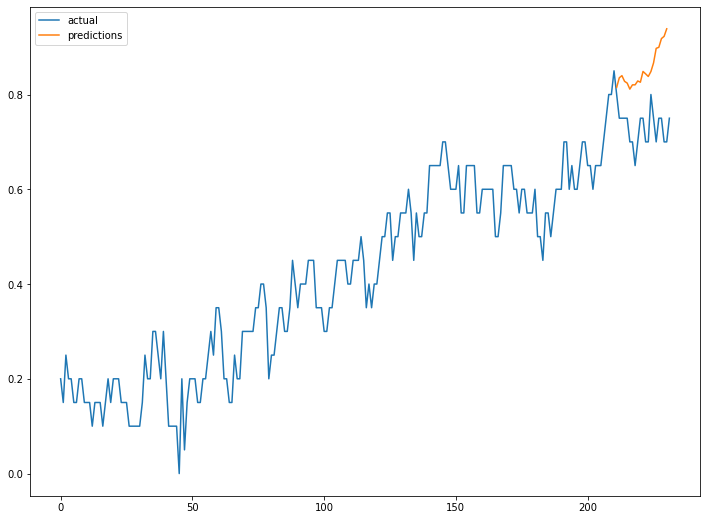

In [25]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 5.2814006805418865 actual 0.8421052631578938 prediction 0.7976303
num 1 5.962211435491368 actual 0.8684210526315788 prediction 0.81664395
num 2 2.5255400687455047 actual 0.8421052631578938 prediction 0.82083756
num 3 6.383606881806325 actual 0.8684210526315788 prediction 0.81298447
num 4 6.526616125395783 actual 0.8684210526315788 prediction 0.81174254
num 5 4.743107780814065 actual 0.8421052631578938 prediction 0.8021633
num 6 0.1880018941816773 actual 0.8157894736842097 prediction 0.8142558
num 7 0.09939747471953474 actual 0.8157894736842097 prediction 0.8149786
num 8 1.9426342099903924 actual 0.8421052631578938 prediction 0.82574624
num 9 2.0085521042345866 actual 0.8421052631578938 prediction 0.82519114
num 10 2.3452979145627824 actual 0.8684210526315788 prediction 0.848054
num 11 0.6476424634457751 actual 0.8421052631578938 prediction 0.8475591
num 12 5.253634733312236 actual 0.8947368421052628 prediction 0.84773064
num 13 0.9778080564556486 actual 0.8684210526315788 predict

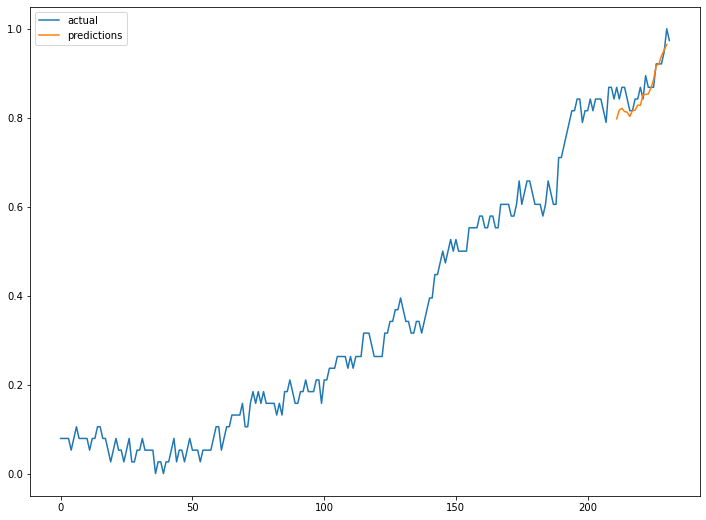

In [26]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_20.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 0.48433244228373645 actual 0.76923076923077 prediction 0.76550514
num 1 6.773134281760629 actual 0.7307692307692317 prediction 0.7802652
num 2 7.337461019817011 actual 0.7307692307692317 prediction 0.78438914
num 3 6.901426691757866 actual 0.7307692307692317 prediction 0.78120273
num 4 13.153705332014406 actual 0.6923076923076916 prediction 0.7833718
num 5 1.356394886970412 actual 0.76923076923077 prediction 0.7796646
num 6 2.140417553129733 actual 0.8076923076923084 prediction 0.7904043
num 7 1.9170954113915684 actual 0.8076923076923084 prediction 0.7922081
num 8 5.0645568154075535 actual 0.8461538461538467 prediction 0.8032999
num 9 0.24934496198390135 actual 0.8076923076923084 prediction 0.80567837
num 10 7.005793452262764 actual 0.76923076923077 prediction 0.8231215
num 11 7.39474236965168 actual 0.76923076923077 prediction 0.8261134
num 12 7.891265153884773 actual 0.76923076923077 prediction 0.8299328
num 13 4.1864502997624555 actual 0.8076923076923084 prediction 0.84150594


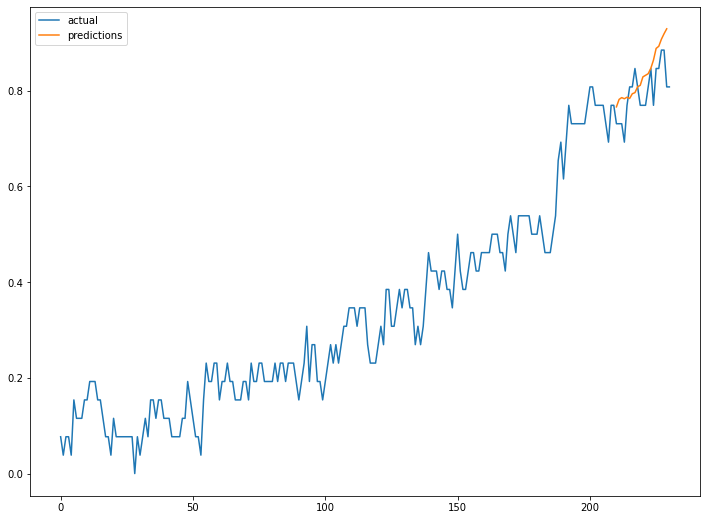

In [27]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_22.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 0.5791472196578662 actual 0.7389162561576352 prediction 0.73463684
num 1 0.36149099469184526 actual 0.7487684729064039 prediction 0.74606174
num 2 0.5256728409162051 actual 0.7536945812807878 prediction 0.7497326
num 3 1.1564774946732617 actual 0.7586206896551722 prediction 0.7498474
num 4 1.8149144374407191 actual 0.7684729064039408 prediction 0.7545258
num 5 2.2747772894087936 actual 0.7733990147783252 prediction 0.7558059
num 6 1.8840196389185875 actual 0.7783251231527091 prediction 0.7636613
num 7 2.117356789187043 actual 0.7832512315270934 prediction 0.766667
num 8 1.3500853627920057 actual 0.7881773399014778 prediction 0.7775363
num 9 1.4290762984234393 actual 0.7931034482758621 prediction 0.7817694
num 10 0.49181157424122296 actual 0.798029556650246 prediction 0.79410475
num 11 0.14704738134223194 actual 0.798029556650246 prediction 0.79920304
num 12 0.5059611870021233 actual 0.8078817733990147 prediction 0.8037942
num 13 1.072415191970158 actual 0.8226600985221673 predict

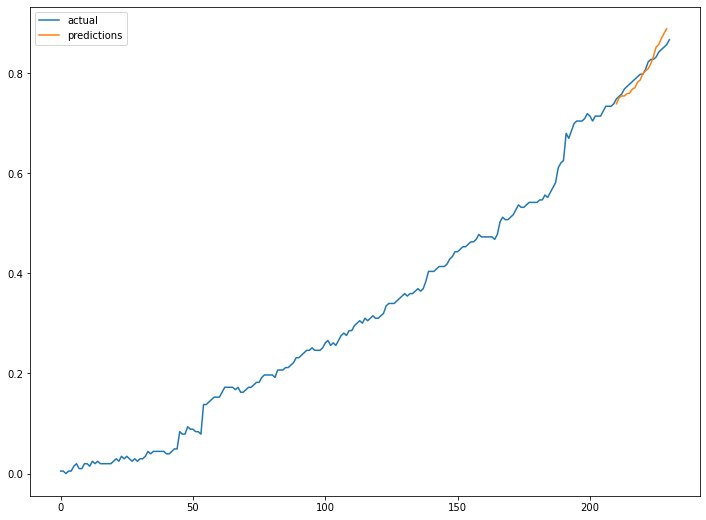

In [28]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_23.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()